In [3]:
import innvestigate
import innvestigate.utils
import keras.applications.vgg16 as vgg16

eutils = imp.load_source("utils", "../utils.py")

# Get some example test set images.
images, label_to_class_name = eutils.get_imagenet_data(net["image_shape"][0])

if not len(images):
    raise Exception("Please download the example images using: "
                    "'innvestigate/examples/images/wget_imagenet_2011_samples.sh'")

# Choose a sample image and add batch axis
image = images[0][0][None, :, :, :]
# Preprocess it for VGG16
image_pp = imgnetutils.preprocess(image, net)
# Displaying the image
plot.imshow(image[0]/255)
plot.show()

# Get model
model, preprocess = vgg16.VGG16(), vgg16.preprocess_input
# Strip softmax layer
model = innvestigate.utils.model_wo_softmax(model)

# Create analyzer
analyzer = innvestigate.create_analyzer("deep_taylor", model)

# Add batch axis and preprocess
x = preprocess(image[None])
# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(x)

# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))

NameError: name 'imp' is not defined

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
import innvestigate
import innvestigate.utils
import numpy as np
import matplotlib.pyplot as plt
import keras

from PIL import Image

from utils.explain import get_classifier, create_train_val, get_datasets, ClassifierTrainer

In [12]:
IMG_HEIGHT = 128
model, preprocessing_layer = get_classifier((IMG_HEIGHT,IMG_HEIGHT,3))

In [13]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
def lr_schedule(epoch, lr):
    """
    Returns a custom learning rate that decreases as epochs progress.
    """
    if epoch <= 25:
        return lr
    if epoch <= 50:
        return lr/10
    if epoch <= 75:
        return lr/100
    else:
        return lr/1000

optimiser = keras.optimizers.Adam(lr=1e-3)

In [14]:
train_dataset, val_dataset = get_datasets('classifier_train_data',
                                          'classifier_val_data',
                                          preprocessing_layer,
                                          img_height=IMG_HEIGHT,
                                          img_width=IMG_HEIGHT,
                                          batch_size=32)

Found 3745 images belonging to 19 classes.
Found 913 images belonging to 19 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


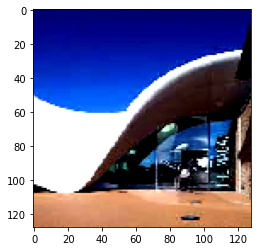

In [15]:
X, y = next(iter(val_dataset))
plt.imshow(X[1]*0.5+0.5)
plt.show()

In [16]:
trainer = ClassifierTrainer(train_dataset, val_dataset, model, optimiser, lr_schedule)

In [17]:
trainer.train(epochs = 1)

Epoch 1/1
118/118 [==============================] - 434s 4s/step - loss: 1.5222 - acc: 0.6001 - val_loss: 2.0872 - val_acc: 0.5739

Epoch 00001: saving model to /Users/starlight/Desktop/creative-machine-learning/classifier_1x_checkpoints/cp.ckpt


KeyboardInterrupt: 

In [36]:
from glob import glob
infer_datadir = 'classifier_infer_data'
file_paths = glob(os.path.join(infer_datadir,'*.jpeg')) + glob(os.path.join(infer_datadir,'*.jpg'))

In [41]:

preprocessing_layer(np.array(keras.preprocessing.image.load_img(file_paths[0], target_size=(IMG_HEIGHT,IMG_HEIGHT))))

array([[[ 0.07406463,  0.74789923,  1.7685405 ],
        [-0.06293353,  0.6078432 ,  1.6291069 ],
        [-0.11430778,  0.55532223,  1.5768193 ],
        ...,
        [-0.16568205,  0.45028022,  1.5071026 ],
        [-0.14855729,  0.4677872 ,  1.5245317 ],
        [-0.11430778,  0.50280124,  1.5593902 ]],

       [[-0.14855729,  0.5203082 ,  1.541961  ],
        [-0.11430778,  0.55532223,  1.5768193 ],
        [-0.11430778,  0.55532223,  1.5768193 ],
        ...,
        [-0.16568205,  0.45028022,  1.5071026 ],
        [-0.16568205,  0.45028022,  1.5071026 ],
        [-0.16568205,  0.45028022,  1.5071026 ]],

       [[-0.14855729,  0.5203082 ,  1.5593902 ],
        [-0.09718303,  0.57282925,  1.6116778 ],
        [-0.06293353,  0.6078432 ,  1.6465361 ],
        ...,
        [-0.18280679,  0.4327732 ,  1.4896734 ],
        [-0.16568205,  0.45028022,  1.5071026 ],
        [-0.13143253,  0.48529422,  1.541961  ]],

       ...,

       [[-1.3815396 , -1.2829131 , -1.229281  ],
        [-1

In [48]:
trainer.infer('classifier_infer_data', preprocessing_layer, IMG_HEIGHT, IMG_HEIGHT)

Inference Completed


In [47]:
model.predict

<bound method Model.predict of <keras.engine.training.Model object at 0x7f7f24f64d10>>

In [6]:
analyzer = innvestigate.create_analyzer("deep_taylor", model)

In [16]:
preprocessing_layer(np.array(Image.open('classifier_data/google_pavilion_2000/0385529262.jpg'))).shape

(600, 900, 3)

In [44]:
keras.backend

<module 'keras.backend' from '/Users/starlight/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/keras/backend/__init__.py'>

In [57]:
create_train_val()

Completed for google_pavilion_2011
Completed for google_pavilion_2016
Completed for google_pavilion_2018
Completed for google_pavilion_2019
Completed for google_pavilion_2017
Completed for google_pavilion_2010
Completed for google_pavilion_2003
Completed for google_pavilion_2005
Completed for google_pavilion_2002
Completed for google_pavilion_2015
Completed for google_pavilion_2012
Completed for google_pavilion_2013
Completed for google_pavilion_2014
Completed for google_pavilion_2009
Completed for google_pavilion_2007
Completed for google_pavilion_2000
Completed for google_pavilion_2001
Completed for google_pavilion_2006
Completed for google_pavilion_2008
Completed Generation of Train and Val Sets


In [38]:
os.getcwd()

'/Users/starlight/Desktop/creative-machine-learning'

In [49]:
from glob import glob
glob('/Users/starlight/Desktop/creative-machine-learning/classifier_data/*')[0]

'/Users/starlight/Desktop/creative-machine-learning/classifier_data/google_pavilion_2011'

In [50]:
os.getcwd()

'/Users/starlight/Desktop/creative-machine-learning'